In [30]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision import transforms 
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision.transforms import ToTensor, Normalize, Compose
from PIL import Image
import math
from torch.utils.data import DataLoader
import numpy as np
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from accelerate import Accelerator
from transformers import AdamW, get_cosine_schedule_with_warmup
import timeit
from tqdm.auto import tqdm

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

## Plot Our Image

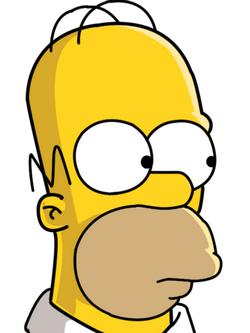

In [32]:
img = Image.open('homer.jpeg')
img

## Preprocess

In [33]:
transform = Compose([
    transforms.Resize((128, 128)),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_tensor = transform(img).unsqueeze(0) 
image_tensor = image_tensor.to("cuda" if torch.cuda.is_available() else "cpu")
print(image_tensor.shape)

torch.Size([1, 3, 128, 128])


## Load Pre-trained model

In [34]:
model = UNet2DModel(
    sample_size=128,  
    in_channels=3,  
    out_channels=3,  
    layers_per_block=2, 
    block_out_channels=(128, 128, 256, 256, 512, 512),  
    down_block_types=(
        "DownBlock2D",  
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  
        "AttnUpBlock2D",  
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

## Noise Scheduler

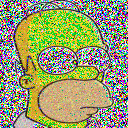

In [35]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(image_tensor.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(image_tensor, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

## Training Loop

In [36]:
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images
    return images[0]


def visualize(image_tensor, noisy_image, predicted_noise, epoch):
    img = image_tensor.squeeze().cpu().detach().numpy()
    noisy_img = noisy_image.squeeze().cpu().detach().numpy()
    pred_noise = predicted_noise.squeeze().cpu().detach().numpy()
    gen_img = sample_image_generation(model, noise_scheduler, 1, 42,1000)
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    axs[0].imshow(img.transpose(1, 2, 0))
    axs[0].set_title('Original Image')
    axs[1].imshow(noisy_img.transpose(1, 2, 0))
    axs[1].set_title('Noisy Image')
    axs[2].imshow(pred_noise.transpose(1, 2, 0))
    axs[2].set_title('Predicted Noise')
    axs[3].imshow(gen_img)
    axs[3].set_title("Generated Sample")

    for ax in axs:
        ax.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

In [37]:

NUM_EPOCHS = 5000
LEARNING_RATE = 5e-5
NUM_WARMUP_STEPS = 500
MIXED_PRECISION = "no" 
GRADIENT_ACCUMULATION_STEPS = 1
NUM_GENERATE_IMAGES = 1 
RANDOM_SEED = 42
NUM_TIMESTEPS = 50

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=NUM_EPOCHS  
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, lr_scheduler = accelerator.prepare(model, optimizer, lr_scheduler)


image_tensor = image_tensor.to(accelerator.device)  
noise_scheduler = noise_scheduler = DDPMScheduler(num_train_timesteps=1000)



/Users/alexisrevelle/Documents/Deep_Learning/.conda/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


We test the model before training

100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


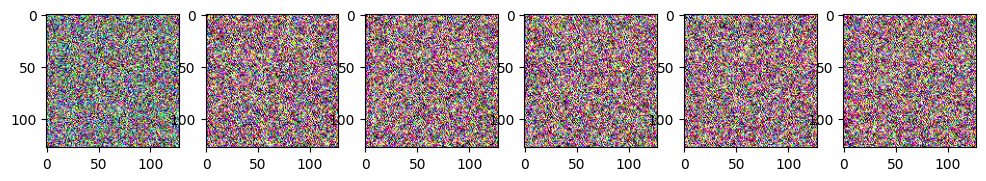

In [38]:
steps = [1, 75, 125, 250, 500, 1000]

fig, axs = plt.subplots(1, len(steps), figsize=(12, 4))

for idx in range(0, len(steps)):
    gen_img = sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, steps[idx])
    axs[idx].imshow(gen_img)


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0: Loss = 1.2263


100%|██████████| 1000/1000 [02:23<00:00,  6.99it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


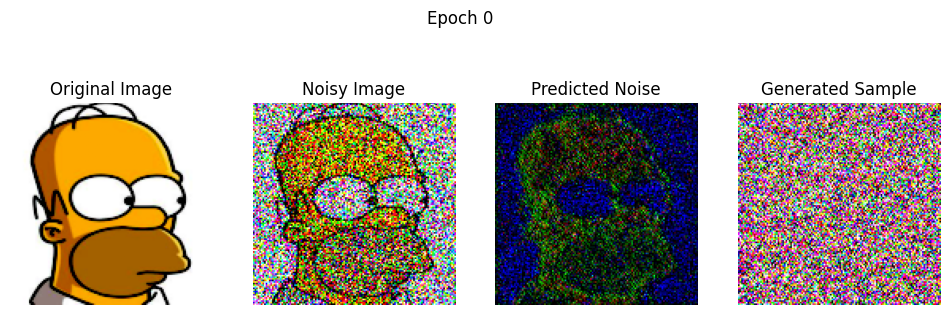

 20%|██        | 1000/5000 [19:59<55:00,  1.21it/s]  

Epoch 1000: Loss = 0.0084


100%|██████████| 1000/1000 [02:06<00:00,  7.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


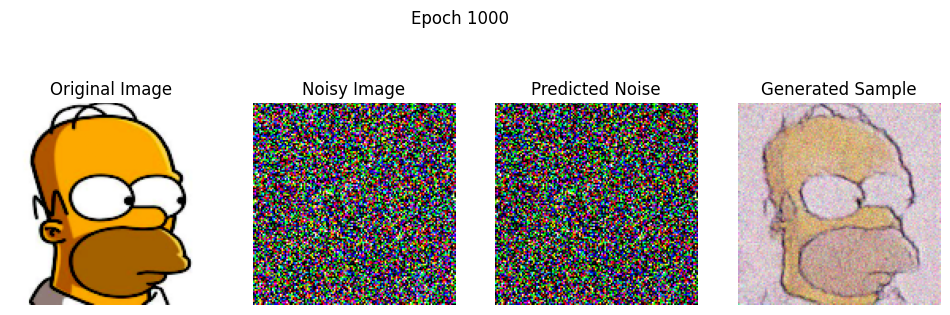

 40%|████      | 2000/5000 [36:13<41:07,  1.22it/s]   

Epoch 2000: Loss = 0.0017


100%|██████████| 1000/1000 [02:06<00:00,  7.89it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


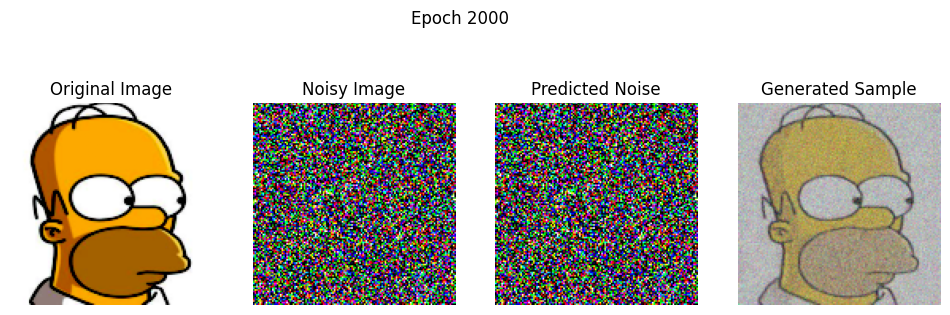

 60%|██████    | 3000/5000 [52:19<29:41,  1.12it/s]   

Epoch 3000: Loss = 0.0019


100%|██████████| 1000/1000 [02:06<00:00,  7.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


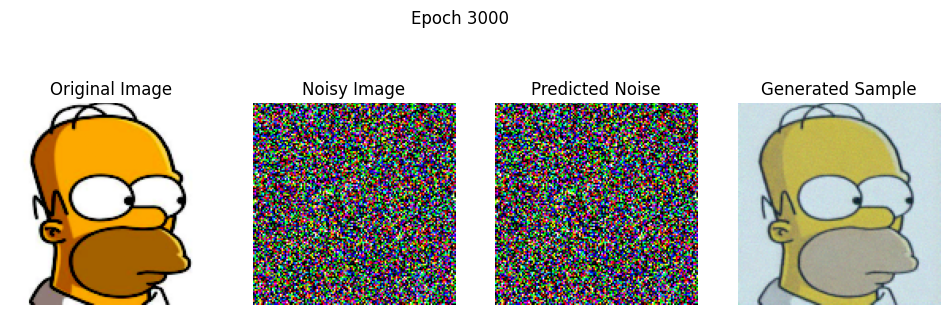

 80%|████████  | 4000/5000 [1:08:21<13:19,  1.25it/s] 

Epoch 4000: Loss = 0.0009


100%|██████████| 1000/1000 [02:04<00:00,  8.02it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


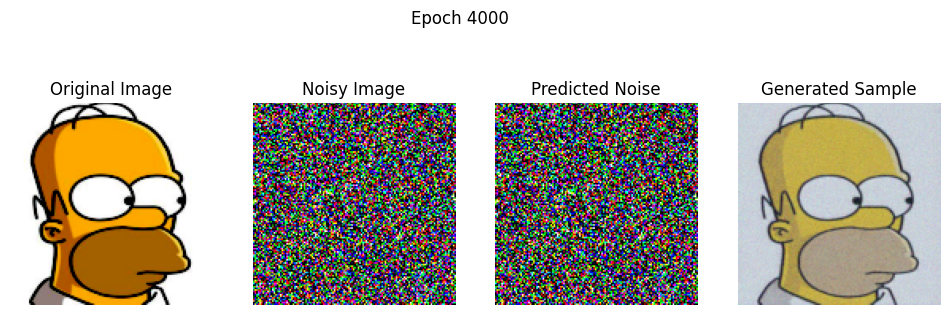

100%|██████████| 5000/5000 [1:24:56<00:00,  1.02s/it]   

Training Time: 5096.83s


In [39]:
loss_values = []
noisy_images = []
noise_preds = []

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    
    noise = torch.randn(image_tensor.shape).to(accelerator.device)
    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (1,)).to(accelerator.device)
    noisy_image = noise_scheduler.add_noise(image_tensor, noise, timesteps)
    noisy_images.append(noisy_image)

    with accelerator.accumulate(model):
        noise_pred = model(noisy_image, timesteps, return_dict=False)[0]
        noise_preds.append(noise_pred)
        loss = F.mse_loss(noise_pred, noise)
        loss_values.append(loss)
        accelerator.backward(loss)
        
        accelerator.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step() 
        optimizer.zero_grad()
    
    
    if (epoch) % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
        visualize(image_tensor, noisy_image, noise_pred, epoch)
        

stop = timeit.default_timer()
print(f"Training Time: {stop - start:.2f}s")

## Evaluate Image Generation

100%|██████████| 1000/1000 [02:03<00:00,  8.08it/s]


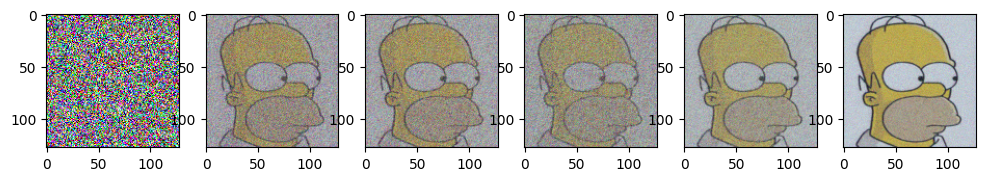

In [40]:
steps = [1, 75, 125, 250, 500, 1000]
fig, axs = plt.subplots(1, len(steps), figsize=(12, 4))

for idx in range(0, len(steps)):
    gen_img = sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, steps[idx])
    axs[idx].imshow(gen_img)